In [2]:
!date

Wed Jun 11 10:27:01 AM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [42]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import ants
from tqdm import tqdm
import warnings


In [32]:
import ants

In [24]:
indir = '../Data/things/fmriprep2'

In [25]:
sub = 'sub-01'
sess_name = 'ses-localizer2' if sub=='sub-01' else 'ses-localizer1'

In [27]:
func_imgs = []
events_tsv = []
confounds_tsv = []


for r in [1,2,3,4]:
    epi_fn = os.path.join(indir,sub,sess_name,'func',f'{sub}_{sess_name}_task-6cat_run-{r:02d}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
    anat_fn = os.path.join(indir,sub,'anat',f'{sub}_rec-pydeface_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
    anat_gm_fn = os.path.join(indir,sub,'anat',f'{sub}_rec-pydeface_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
    anat_wm_fn = os.path.join(indir,sub,'anat',f'{sub}_rec-pydeface_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
    anat_csf_fn = os.path.join(indir,sub,'anat',f'{sub}_rec-pydeface_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')
    conf_fn = os.path.join(indir,sub,sess_name,'func',f'{sub}_{sess_name}_task-6cat_run-01_desc-confounds_timeseries.tsv')
    events_fn = f'../Data/things/ds004192/{sub}/{sess_name}/func/{sub}_{sess_name}_task-6cat_run-{r:02d}_events.tsv'

    assert os.path.exists(epi_fn), 'epi_fn does not exist'
    assert os.path.exists(anat_fn), 'anat_fn does not exist'
    assert os.path.exists(anat_gm_fn), 'anat_gm_fn does not exist'
    assert os.path.exists(anat_wm_fn), 'anat_wm_fn does not exist'
    assert os.path.exists(anat_csf_fn), 'anat_csf_fn does not exist'
    assert os.path.exists(conf_fn), f'conf_fn does not exist:\n{conf_fn}'
    assert os.path.exists(events_fn), f'events_fn does not exist:\n{events_fn}'


    func_imgs.append(epi_fn)
    events_tsv.append(events_fn)
    confounds_tsv.append(conf_fn)

In [29]:
first_level_model = FirstLevelModel(
    t_r=1.5,                   # replace with your TR
    slice_time_ref=0.5,        # reference slice (0–1)
    hrf_model='spm',           # canonical SPM HRF
    drift_model='cosine',
    high_pass=0.01,            # cutoff (Hz)
    noise_model='ar1',
    smoothing_fwhm=6.0,        # in mm
    verbose=1)

In [46]:
pd.unique(pd.read_csv(events_tsv[0],delimiter='\t')['trial_type'])

array(['bodyparts', 'words', 'scrambled', 'faces', 'scenes', 'objects'],
      dtype=object)

In [57]:
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel

In [38]:
first_level_model = first_level_model.fit(
    run_imgs=func_imgs,
    events=events_tsv,
    confounds=None)

Computing run 1 out of 4 runs (go take a coffee, a big one)
Computing run 2 out of 4 runs (39 seconds remaining)
Computing run 3 out of 4 runs (26 seconds remaining)
Computing run 4 out of 4 runs (13 seconds remaining)

Computation of 4 runs done in 52.75923943519592 seconds.



In [47]:
contrast_def = {
    'faces': 5,               # weight for faces
    'bodyparts': -1,           # combined weight for all others
    'scenes': -1,
    'objects': -1,
    'words': -1,
}

In [51]:
dm = first_level_model.design_matrices_[0]
print(dm.columns) 

Index(['bodyparts', 'faces', 'objects', 'scenes', 'scrambled', 'words',
       'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'constant'],
      dtype='object')


In [54]:
contrast_vec = np.array([0,4,-1,-1,-1,-1,0,0,0,0])

In [64]:
z_map = first_level_model.compute_contrast(
    contrast_vec, 
    output_type='z_score'
)

<ipython-input-64-a7a9db74a61c>:1: UserWarning: One contrast given, assuming it for all 4 runs
  z_map = first_level_model.compute_contrast(
/home/aglinska/anaconda3/lib/python3.8/site-packages/nilearn/glm/contrasts.py:108: UserWarning: t contrasts should be of length P=12, but it has length 10. The rest of the contrast was padded with zeros.
  reg = regression_result[label_].Tcontrast(con_val)


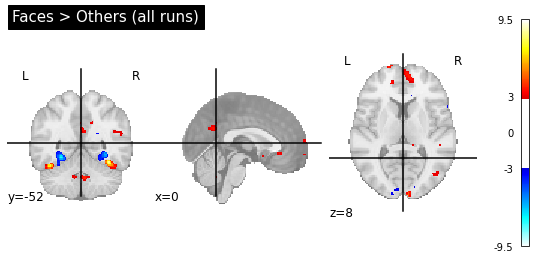

In [65]:
display = plotting.plot_stat_map(
    z_map,
    threshold=3.0,
    display_mode='ortho',
    cut_coords=(0, -52, 8),
    title='Faces > Others (all runs)'
)
plotting.show()

In [66]:
z_map.to_filename('../Data/things/GLM/sub-01-face.nii')